In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
import numpy as np
import folium
import geopandas as gpd
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import itertools
from folium.plugins import MarkerCluster
import re
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
##from matplotlib.animation import FuncAnimation
##from scipy.stats import gaussian_kde
import time
from shapely.geometry import Point
###import contextily as ctx
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

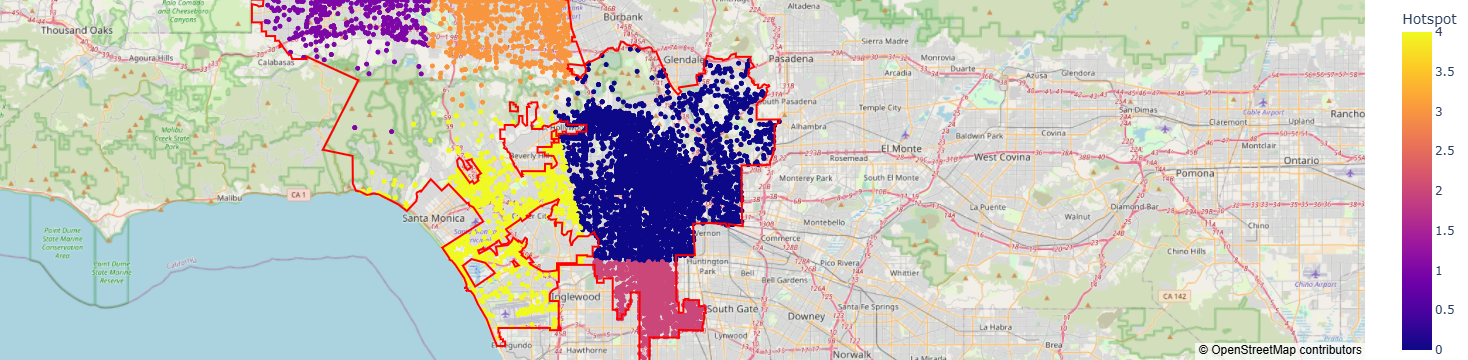

In [2]:
# kmeans_spatial_clustering.py

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import json

# Load the data
df = pd.read_csv("Time_formatted_fixed_loc.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df[['Datetime', 'LAT', 'LON']].dropna()

# Standardize LAT and LON
scaler = StandardScaler()
df[['LAT_std', 'LON_std']] = scaler.fit_transform(df[['LAT', 'LON']])

# KMeans on standardized coordinates
kmeans = KMeans(n_clusters=5, random_state=42)
df['Hotspot'] = kmeans.fit_predict(df[['LAT_std', 'LON_std']])

# Load LA boundary GeoJSON
with open("la_boundary.geojson", "r") as f:
    la_boundary = json.load(f)

# Visualize using original coordinates
fig = px.scatter_mapbox(
    df.sample(frac=0.05, random_state=42),
    lat="LAT",
    lon="LON",
    color="Hotspot",
    zoom=9.5,
    center={"lat": 34.05, "lon": -118.25},
    height=800
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_layers=[
        {"source": la_boundary, "type": "line", "color": "red"},
    ],
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.show()


In [3]:
df['Hotspot'].value_counts()

Hotspot
0    154953
3     66161
2     44947
4     36068
1     32427
Name: count, dtype: int64

In [4]:
df['Date'] = df['Datetime'].dt.to_period('W').apply(lambda r: r.start_time)

In [5]:
time_series = df.groupby(['Date', 'Hotspot']).size().reset_index(name='CrimeCount')
ts_pivot = time_series.pivot(index='Date', columns='Hotspot', values='CrimeCount').fillna(0)
ts_pivot = ts_pivot.sort_index()
ts_pivot.index = pd.DatetimeIndex(ts_pivot.index, freq='W-MON')  # Explicit frequency for 

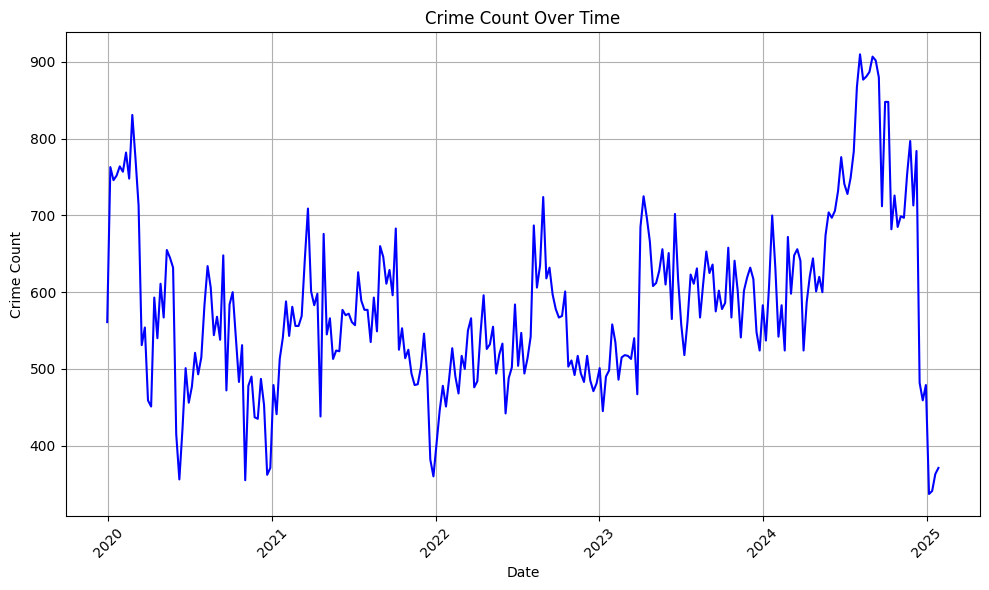

In [6]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot[0].index, ts_pivot[0], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

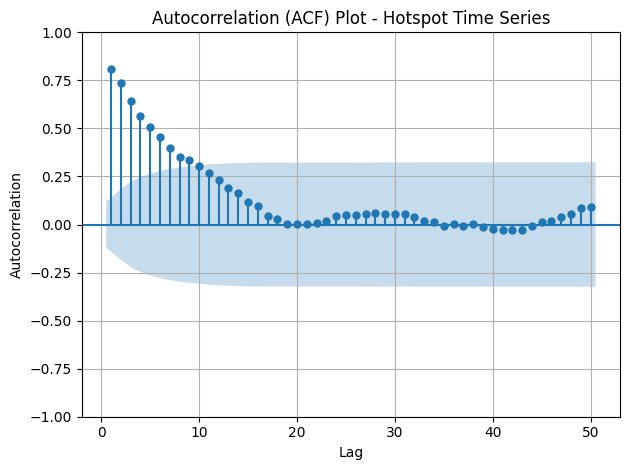

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[0].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

# Models

### ADF Test

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
##from statsmodels.stats.diagnostic import acorr_ljungbox
##import pmdarima as pm

# --- Suppress warnings and logs ---
warnings.filterwarnings("ignore")

hotspot_series = ts_pivot[0].values
dates = ts_pivot.index

# === Train-Test Split (90/10) ===
split_idx = int(len(hotspot_series) * 0.8)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")


== ADF Stationarity Test ==
ADF Statistic: -4.5290
p-value: 0.0002
=> Stationary


### AR

In [9]:
import numpy as np
import warnings
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Preprocessing ---
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test Split (80/20 on time series directly) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train, test = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# --- Fit AR model with different lags and select the best ---
best_ar_rmse = float('inf')
best_ar_lag = None

for lag in range(1, 40):  # testing lag values from 1 to 39
    try:
        model_ar = AutoReg(train.flatten(), lags=lag, old_names=False).fit()
        pred_scaled = model_ar.predict(start=len(train), end=len(train) + len(test) - 1)
        
        pred = inverse_transform(pred_scaled)
        actual = inverse_transform(test.flatten())

        rmse = np.sqrt(mean_squared_error(actual, pred))

        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred
            best_ar_actual = actual
    except:
        continue

# --- Results ---
print(f"Best AR Lag: {best_ar_lag}")
print(f"AR RMSE: {best_ar_rmse:.2f}")
print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred)*100:.2f}%")


Best AR Lag: 1
AR RMSE: 187.32
AR MAPE: 23.56%


### SARIMA

In [10]:
import warnings
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Preprocessing ---
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test Split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train, test = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# --- Parameter Ranges ---
p = d = q = range(0, 2)
P = D = Q = range(0, 3)
s = 7  # Weekly seasonality

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            # Forecast the same length as the test set
            pred_scaled = model.forecast(steps=len(test))
            pred = inverse_transform(pred_scaled)
            actual = inverse_transform(test.flatten())

            rmse = np.sqrt(mean_squared_error(actual, pred))
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
                best_pred = pred
                best_actual = actual
        except:
            continue

# --- Output Best SARIMA Model ---
print(f"Best SARIMA Order: {best_order}, Seasonal: {best_seasonal_order} x {s}")
print(f"SARIMA RMSE: {best_rmse:.2f}")
print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_actual, best_pred)*100:.2f}%")


Best SARIMA Order: (0, 1, 0), Seasonal: (2, 2, 2) x 7
SARIMA RMSE: 151.81
SARIMA MAPE: 19.92%


### XGBoost

In [29]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[0].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 180.33
XGBoost MAPE: 21.19%


### SARIMAX


For lag = 1
Test RMSE: 75.4364
MAPE: 8.61%

For lag = 2
Test RMSE: 73.5611
MAPE: 8.56%

For lag = 3
Test RMSE: 73.4773
MAPE: 8.46%

For lag = 4
Test RMSE: 74.8183
MAPE: 8.64%

For lag = 6
Test RMSE: 75.6568
MAPE: 9.06%

For lag = 9
Test RMSE: 76.3351
MAPE: 9.48%

For lag = 12
Test RMSE: 77.5804
MAPE: 9.39%

For lag = 16
Test RMSE: 82.5607
MAPE: 10.19%

For lag = 24
Test RMSE: 85.5490
MAPE: 10.84%

For lag = 30
Test RMSE: 89.3786
MAPE: 11.56%

For lag = 40
Test RMSE: 92.8067
MAPE: 11.59%

For lag = 50
Test RMSE: 92.7308
MAPE: 11.52%


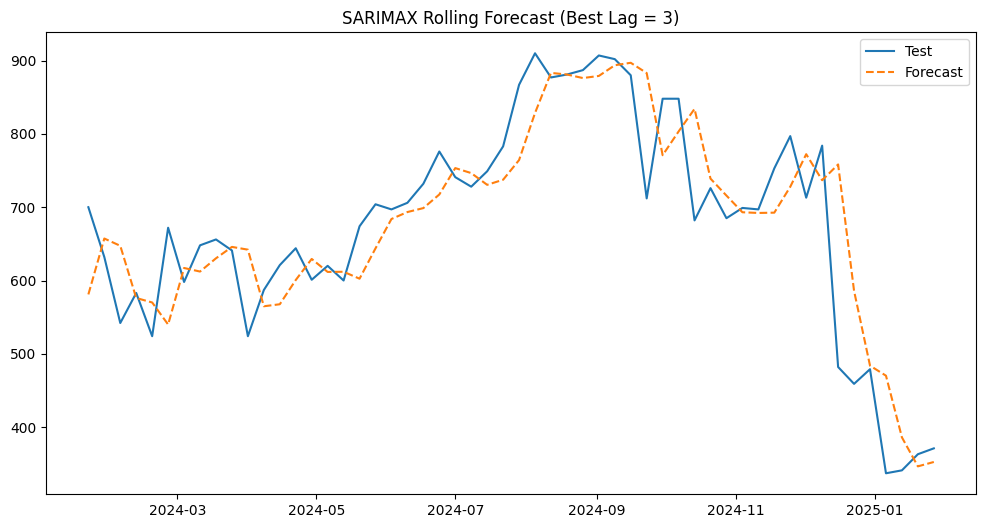

In [11]:
# ================== Cell 6: SARIMA Forecasting with Lag Optimization ==================
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[0].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


### LSTM

Epoch 1, Loss: 0.1372
Epoch 2, Loss: 0.1103
Epoch 3, Loss: 0.1109
Epoch 4, Loss: 0.1137
Epoch 5, Loss: 0.1094
Epoch 6, Loss: 0.1050
Epoch 7, Loss: 0.1042
Epoch 8, Loss: 0.1095
Epoch 9, Loss: 0.0968
Epoch 10, Loss: 0.0905
Epoch 11, Loss: 0.0894
Epoch 12, Loss: 0.1017
Epoch 13, Loss: 0.0893
Epoch 14, Loss: 0.0780
Epoch 15, Loss: 0.0817
Epoch 16, Loss: 0.0854
Epoch 17, Loss: 0.0861
Epoch 18, Loss: 0.0867
Epoch 19, Loss: 0.0854
Epoch 20, Loss: 0.0833
Epoch 21, Loss: 0.0826
Epoch 22, Loss: 0.0826
Epoch 23, Loss: 0.0781
Epoch 24, Loss: 0.0818
Epoch 25, Loss: 0.0832
Epoch 26, Loss: 0.0803
Epoch 27, Loss: 0.0756
Epoch 28, Loss: 0.0784
Epoch 29, Loss: 0.0767
Epoch 30, Loss: 0.0780
Epoch 31, Loss: 0.0779
Epoch 32, Loss: 0.0815
Epoch 33, Loss: 0.0758
Epoch 34, Loss: 0.0834
Epoch 35, Loss: 0.0758
Epoch 36, Loss: 0.0784
Epoch 37, Loss: 0.0734
Epoch 38, Loss: 0.0741
Epoch 39, Loss: 0.0736
Epoch 40, Loss: 0.0764
Epoch 41, Loss: 0.0764
Epoch 42, Loss: 0.0742
Epoch 43, Loss: 0.0788
Epoch 44, Loss: 0.07

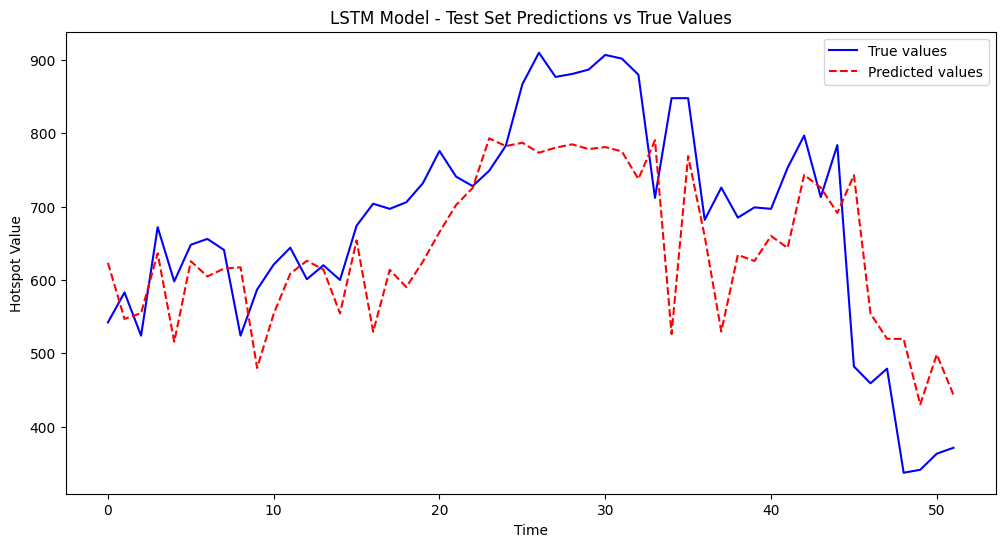

Test RMSE: 104.3898
Test MAPE: 13.32%


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming ts_pivot is a pandas DataFrame with time series data
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# Prepare sequences (7 weeks in → 1 week out)
def create_sequences(data, seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Create sequences for input features and labels
X, y = create_sequences(hotspot_scaled)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert the data to tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Create DataLoader for the training set
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=4, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])
        return self.fc(out)

# Initialize model, loss function, and optimizer
model = LSTMModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(200):
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# After training, evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor)
    print(f"Test Loss (L1): {test_loss.item():.4f}")

# Inverse transform to get the predictions in the original scale
y_test_original = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="True values", color='blue')
plt.plot(y_pred_original, label="Predicted values", color='red', linestyle='--')
plt.title("LSTM Model - Test Set Predictions vs True Values")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape * 100:.2f}%")


# Cluster 3

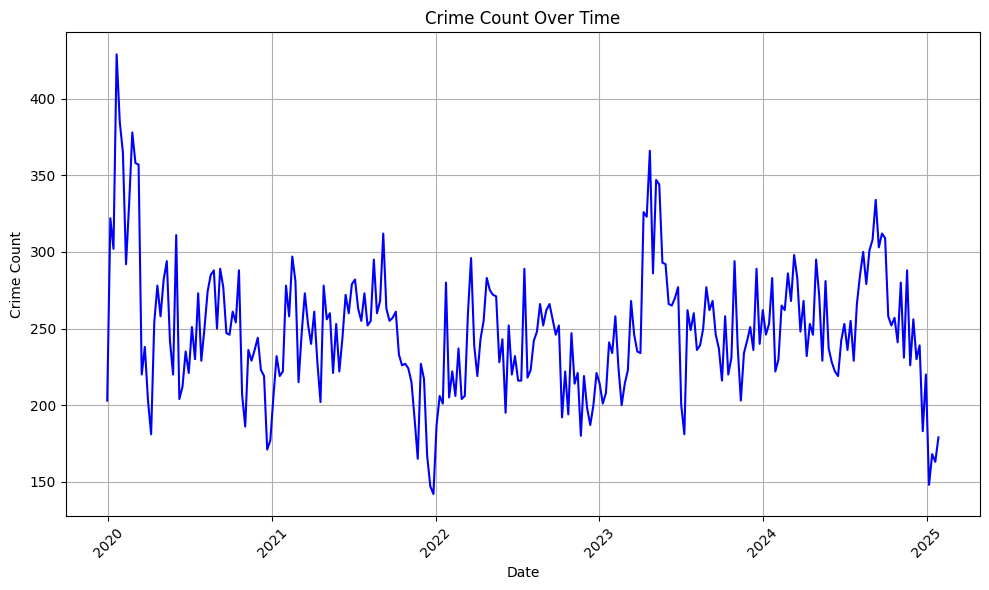

In [16]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot[0].index, ts_pivot[3], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

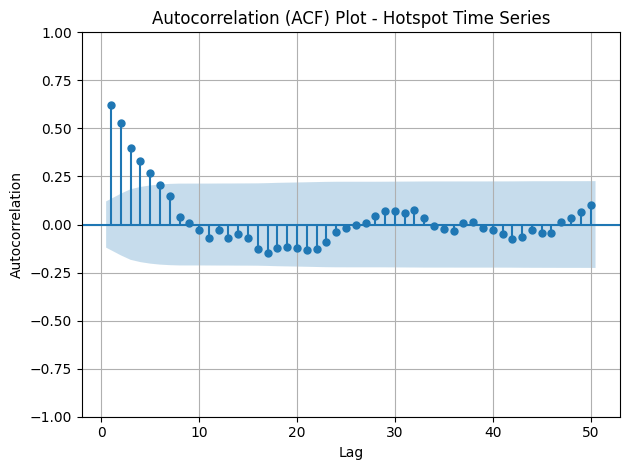

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[3].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
##from statsmodels.stats.diagnostic import acorr_ljungbox
##import pmdarima as pm

# --- Suppress warnings and logs ---
warnings.filterwarnings("ignore")

# === Load Time Series Data ===
# Example: ts_pivot should be a DataFrame with datetime index and hotspot series as columns
# You should replace this with actual loading logic
# ts_pivot = pd.read_csv("your_timeseries.csv", index_col=0, parse_dates=True)
hotspot_series = ts_pivot[3].values
dates = ts_pivot.index

# === Train-Test Split (90/10) ===
split_idx = int(len(hotspot_series) * 0.8)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")


== ADF Stationarity Test ==
ADF Statistic: -4.7808
p-value: 0.0001
=> Stationary


In [19]:
import numpy as np
import warnings
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Preprocessing ---
hotspot_series = ts_pivot[3].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test Split (80/20 on time series directly) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train, test = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# --- Fit AR model with different lags and select the best ---
best_ar_rmse = float('inf')
best_ar_lag = None

for lag in range(1, 40):  # testing lag values from 1 to 39
    try:
        model_ar = AutoReg(train.flatten(), lags=lag, old_names=False).fit()
        pred_scaled = model_ar.predict(start=len(train), end=len(train) + len(test) - 1)
        
        pred = inverse_transform(pred_scaled)
        actual = inverse_transform(test.flatten())

        rmse = np.sqrt(mean_squared_error(actual, pred))

        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred
            best_ar_actual = actual
    except:
        continue

# --- Results ---
print(f"Best AR Lag: {best_ar_lag}")
print(f"AR RMSE: {best_ar_rmse:.2f}")
print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred)*100:.2f}%")


Best AR Lag: 1
AR RMSE: 39.22
AR MAPE: 13.08%


In [20]:
import warnings
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Preprocessing ---
hotspot_series = ts_pivot[3].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test Split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train, test = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# --- Parameter Ranges ---
p = d = q = range(0, 2)
P = D = Q = range(0, 3)
s = 7  # Weekly seasonality

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            # Forecast the same length as the test set
            pred_scaled = model.forecast(steps=len(test))
            pred = inverse_transform(pred_scaled)
            actual = inverse_transform(test.flatten())

            rmse = np.sqrt(mean_squared_error(actual, pred))
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
                best_pred = pred
                best_actual = actual
        except:
            continue

# --- Output Best SARIMA Model ---
print(f"Best SARIMA Order: {best_order}, Seasonal: {best_seasonal_order} x {s}")
print(f"SARIMA RMSE: {best_rmse:.2f}")
print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_actual, best_pred)*100:.2f}%")


Best SARIMA Order: (0, 1, 1), Seasonal: (1, 0, 1) x 7
SARIMA RMSE: 38.95
SARIMA MAPE: 13.08%


In [30]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[3].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 30.35
XGBoost MAPE: 10.12%



For lag = 1
Test RMSE: 31.3158
MAPE: 10.78%

For lag = 2
Test RMSE: 26.8370
MAPE: 9.05%

For lag = 3
Test RMSE: 27.1729
MAPE: 9.23%

For lag = 4
Test RMSE: 27.5557
MAPE: 9.23%

For lag = 6
Test RMSE: 27.8043
MAPE: 9.48%

For lag = 9
Test RMSE: 28.9914
MAPE: 10.04%

For lag = 12
Test RMSE: 28.2665
MAPE: 9.52%

For lag = 16
Test RMSE: 28.5947
MAPE: 9.77%

For lag = 24
Test RMSE: 28.2663
MAPE: 9.64%

For lag = 30
Test RMSE: 28.5988
MAPE: 9.56%

For lag = 40
Test RMSE: 30.1979
MAPE: 9.92%

For lag = 50
Test RMSE: 31.8213
MAPE: 10.85%


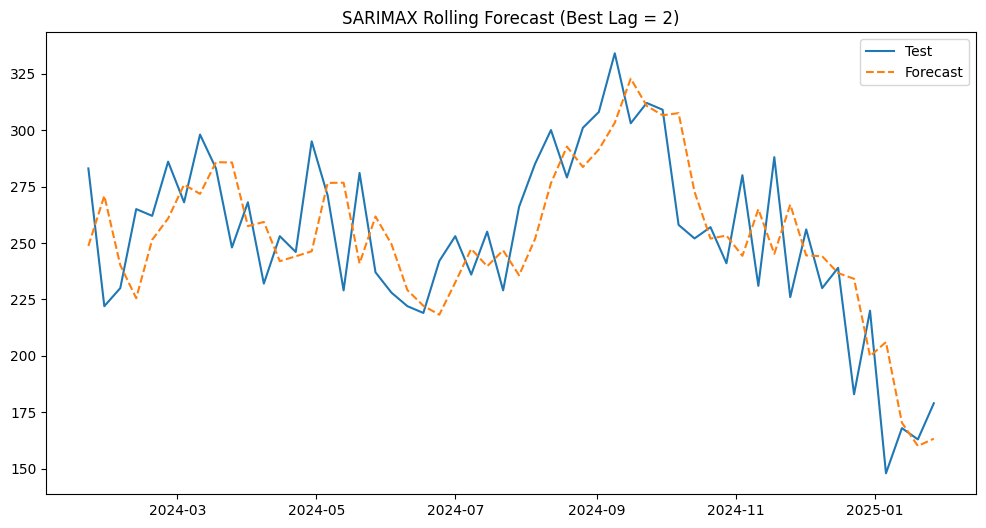

In [31]:
# ================== Cell 6: SARIMA Forecasting with Lag Optimization ==================
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[3].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


Epoch 1, Loss: 0.1785
Epoch 2, Loss: 0.1094
Epoch 3, Loss: 0.1072
Epoch 4, Loss: 0.1033
Epoch 5, Loss: 0.1030
Epoch 6, Loss: 0.1025
Epoch 7, Loss: 0.1047
Epoch 8, Loss: 0.1033
Epoch 9, Loss: 0.1024
Epoch 10, Loss: 0.1028
Epoch 11, Loss: 0.1036
Epoch 12, Loss: 0.1031
Epoch 13, Loss: 0.1037
Epoch 14, Loss: 0.1030
Epoch 15, Loss: 0.1044
Epoch 16, Loss: 0.1016
Epoch 17, Loss: 0.1035
Epoch 18, Loss: 0.1029
Epoch 19, Loss: 0.1029
Epoch 20, Loss: 0.1069
Epoch 21, Loss: 0.1013
Epoch 22, Loss: 0.0998
Epoch 23, Loss: 0.0979
Epoch 24, Loss: 0.0979
Epoch 25, Loss: 0.0966
Epoch 26, Loss: 0.0988
Epoch 27, Loss: 0.0945
Epoch 28, Loss: 0.0935
Epoch 29, Loss: 0.0899
Epoch 30, Loss: 0.0893
Epoch 31, Loss: 0.0921
Epoch 32, Loss: 0.0901
Epoch 33, Loss: 0.0875
Epoch 34, Loss: 0.0853
Epoch 35, Loss: 0.0897
Epoch 36, Loss: 0.0876
Epoch 37, Loss: 0.0900
Epoch 38, Loss: 0.0889
Epoch 39, Loss: 0.0865
Epoch 40, Loss: 0.0840
Epoch 41, Loss: 0.0868
Epoch 42, Loss: 0.0910
Epoch 43, Loss: 0.0901
Epoch 44, Loss: 0.08

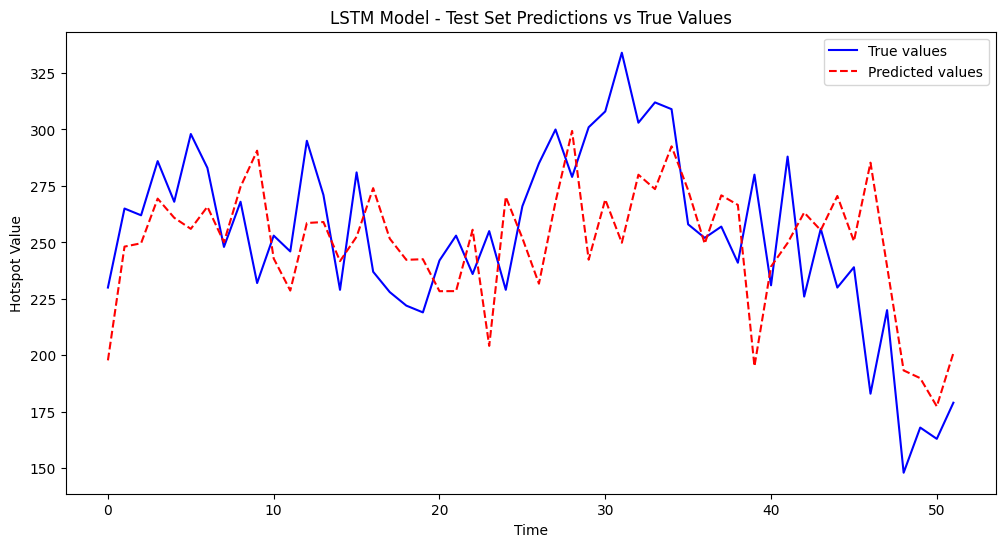

Test RMSE: 35.1879
Test MAPE: 11.47%


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming ts_pivot is a pandas DataFrame with time series data
hotspot_series = ts_pivot[3].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# Prepare sequences (7 weeks in → 1 week out)
def create_sequences(data, seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Create sequences for input features and labels
X, y = create_sequences(hotspot_scaled)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert the data to tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Create DataLoader for the training set
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=4, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])
        return self.fc(out)

# Initialize model, loss function, and optimizer
model = LSTMModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(200):
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# After training, evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor)
    print(f"Test Loss (L1): {test_loss.item():.4f}")

# Inverse transform to get the predictions in the original scale
y_test_original = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="True values", color='blue')
plt.plot(y_pred_original, label="Predicted values", color='red', linestyle='--')
plt.title("LSTM Model - Test Set Predictions vs True Values")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape * 100:.2f}%")
